In [602]:
# !pip install speechbrain==1.0.0
# !pip install torch torchaudio

In [603]:
# !pip install librosa 

In [604]:
from pathlib import Path 
from pydub import AudioSegment
import glob
from tqdm import tqdm
import IPython.display as display
from IPython.display import Audio
import pandas as pd, numpy as np, matplotlib.pyplot as plt

import torchaudio
import librosa
import librosa.display

## Inspect training data 

In [672]:
cats = ['air', 'vac', 'off']
files_path = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei"
#files_path2 = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28"

path = Path(files_path)
#path2 = Path(files_path2)

files = []
for p in path.rglob("*.wav"):
    files.append(str(p))
    #files += glob.glob(f"../data/{cls}/*.wav")
#for p in path2.rglob("*.wav"):
#    files.append(str(p))
#    #files += glob.glob(f"../data/{cls}/*.wav")

In [673]:
print(files)

['/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_8.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_9.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_23.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_22.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_20.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_21.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_25.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_19.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_18.wav', '/Users/jonas/Librar

In [675]:
df = pd.DataFrame(dict(filepath=files))
df["label"] = df.filepath.apply(lambda x: Path(x).parent.name)
df["name"] = df.filepath.apply(lambda x: Path(x).name)
df["duration"] = df.filepath.apply(lambda x: librosa.get_duration(path=x))
df.sample(5)

,filepath,label,name,duration
13,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_16.wav,4.0
22,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_12.wav,4.0
0,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_8.wav,4.0
73,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,off_7.wav,4.0
77,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,off_1.wav,4.0


In [676]:
# drop samples that are to short in duration (< 3.5 secs)
df = df.drop(df[(df.duration < 3.99)].index)
df.duration.value_counts()

duration
4.0    90
Name: count, dtype: int64

In [678]:
# Drop the first sample in all categories
# as first sample often has silence in it
#df_0 = df[df.name.str.contains("_0.wav")]
df = df[~df.name.str.contains("_0.wav")]
#df = df[~df.name.str.contains("_31.wav")]


In [679]:
df.label.value_counts()

label
air    29
vac    29
off    29
Name: count, dtype: int64

In [680]:
def get_sample_of(cls: str, random_state=None):
    return df[df.label == cls].sample(random_state=random_state).iloc[0]
    
def play_sample(sample):
    print(sample.filepath, sample.label)
    return display.Audio(sample.filepath, autoplay=True)

def play_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return play_sample(sample)

In [681]:
def plot_spectrogram(filepath, title=None):
    y, sr = librosa.load(filepath)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-frequency spectrogram ({title})')
    plt.tight_layout()
    plt.show()

def show_sample(sample, **kwargs):
    plot_spectrogram(sample.filepath, **kwargs)

def show_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return show_sample(sample)

## Train/validation split

Split data into training and validation 

In [683]:
from sklearn.model_selection import train_test_split

In [684]:
train, val = train_test_split(df, stratify=df.label, random_state=0, test_size=0.20)
train.shape, val.shape

((69, 4), (18, 4))

In [685]:
df['isval'] = [i in val.index for i in df.index]

In [686]:
df.isval.value_counts()

isval
False    69
True     18
Name: count, dtype: int64

In [687]:
train.label.value_counts()

label
off    23
air    23
vac    23
Name: count, dtype: int64

In [688]:
val.name

3     air_22.wav
65    off_19.wav
13    air_16.wav
16    air_15.wav
79     off_2.wav
82     off_9.wav
67    off_24.wav
91    off_16.wav
36     vac_4.wav
25     air_7.wav
53    vac_29.wav
22    air_12.wav
0      air_8.wav
54    vac_28.wav
35    vac_20.wav
37     vac_5.wav
39    vac_19.wav
62    off_26.wav
Name: name, dtype: object

## Import / download pretrained model (speechbrain urbansound)

In [689]:
import torchaudio
from speechbrain.inference.classifiers import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/urbansound8k_ecapa", savedir="models/gurbansound8k_ecapa")
out_prob, score, index, text_lab = classifier.classify_file('speechbrain/urbansound8k_ecapa/dog_bark.wav')
print(text_lab)

['dog_bark']


# Check that our files are compatible with the downloaded classifier 

In [690]:
import random
rand = random.randint(0,(len(cats) - 1))
sample = get_sample_of(cats[rand], random_state=1)
classifier.classify_file(sample.filepath)

(tensor([[-0.3198, -0.2624,  0.4991, -0.4318, -0.0067, -0.0238,  0.2409,  0.3789,
           0.3183, -0.1127]]),
 tensor([0.4991]),
 tensor([2]),
 ['air_conditioner'])

## Convert audio to tensors for training 

In [691]:
import torchaudio
import torch

In [692]:
df.iloc[0].filepath

'/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_8.wav'

different samples have different length tensor (longer or shorter time series) 

In [693]:
from numpy import random
import numpy as np
from torchaudio import transforms
from torchaudio.io import AudioEffector
import matplotlib.pyplot as plt

class AudioUtil():
    #---------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    #---------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        
        return (sig, sr)

    @staticmethod
    def apply_gain(aud, sig_max=0.9):
        sig, sr = aud
        gn = sig_max / sig.max()

        transform = transforms.Vol(gain=gn, gain_type="amplitude")
        
        sig_amp = transform(sig)
        
        return (sig_amp, sr)
    
    #---------------
    # Convert soundfile to desired number of channels
    #---------------
    @staticmethod
    def rechannel(aud, new_channel):
        
        sig, sr = aud
        
        if sig.shape[0] == new_channel:
            #Nothing todo
            return aud
        
        if (new_channel == 1):
            #Convert stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            #Convert from mono to sterio by duplicating the first channel
            resig = torch.cat([sig,sig])
        return ((resig, sr))
    
    #---------------
    #Resample to make sure samplerate is the same for all files - resample applies to one channel at a time
    #---------------
    @staticmethod
    def resample(aud, newsr):
        
        sig, sr = aud
        
        if (sr == newsr):
            #do nothing
            return aud
        
        num_channels = sig.shape[0]
        
        #resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        
        if (num_channels > 1):
            #Resample the second channel and merge both
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
            
        return ((resig, newsr))
    
    
    #-----------------
    #Pad or turncate the signal to be off a standard length in milliseconds
    #-----------------
    @staticmethod
    def pad_trunc(aud, max_ms):

        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr * max_ms / 1000
        
        if (sig_len > max_len):
            #Turncate the signal to the given length
            print(f"Signal length larger than max length {sig_len} > {max_len}")
            sig = sig[:,:max_len]
        elif (sig_len < max_len):
            print(f"Signal length smaller than max length {sig_len} < {max_len}")

            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            #pad with zeroes
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return (sig, sr)

    #--------------------
    #Shift the signal by a random bit, end of signal is wrapped around 
    #to beginning
    #--------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    #--------------------
    #Add eccho or vibrato to the signal. 
    #This method is intented for the generation of synthetic data,
    #using a limited dataset. 
    #--------------------
    @staticmethod
    def add_rand_effect(aud):
        sig, sr = aud    
        effect = random.randint(0,1)
        if effect ==0:
            delay = random.randint(40,100)
            decay = round(random.uniform(0.2,0.7), 2)
            effect = "aecho=in_gain=0.8:out_gain=0.9:delays={}:decays={}".format(delay, decay)
        elif effect == 1:
            freq = random.randint(9,15)
            decay = round(random.uniform(0.15,0.4), 2)
            effect = "vibrato=f={}:d={}".format(freq, decay)
        effector = AudioEffector(effect=effect, pad_end=False)
        sig_ef = effector.apply(sig.T, int(sr)) # int(sr)
        sig_ef = sig_ef.T

        return (sig_ef, sr)
    
    #----------------------------------
    #Genetate spectrogram
    #----------------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        
        #spec has shape [channel, n_mels, time]
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        #convert to db
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return spec
    
    
    #Augment the spectrogram by masking out some sections of it in both the frequency
    #dimencion (Horizontal) and the time dimension (vertical bars)
    
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec
        
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        
        return np.absolute(aug_spec) # Jonas added np.absolute
    
        

In [694]:
from speechbrain.dataio.preprocess import AudioNormalizer

class LoadTransform():
    def __init__(self):
        self.duration = 4000
        self.sr_classifier = 16000 # this is the required sample rate for the classifier
        self.channel = 1
        self.shift_pct = 0.3
        self.audio_normalizer = AudioNormalizer(sample_rate=self.sr_classifier)
    
    def load_audio(self, file_path, return_spectrogram=False):
        signal = AudioUtil.open(file_path)
        #print(f"Audio tensor shape ={signal[0].shape}")

        signal = AudioUtil.rechannel(signal, self.channel)
        #print(f"rechan tensor shape ={signal[0].shape}")

        signal = AudioUtil.pad_trunc(signal, self.duration)
        #print(f"dur_aud tensor shape ={signal[0].shape}")

        signal = AudioUtil.time_shift(signal, self.shift_pct)
        #print(f"ts_aud tensor shape ={signal[0].shape}")
    
        if return_spectrogram:
            return AudioUtil.spectro_gram(signal)

        signal, sr = signal[0].T, signal[1]
        #print(f"Audio sample rate ={sr}")


        return self.audio_normalizer(signal, sr)

In [695]:
from torch.utils.data import DataLoader, Dataset, random_split
#----------------
#Sound dataset
#----------------
    
class SoundDS(Dataset):
    def __init__(self, X, y):
        #self.df = df
        #self.data_paths = data_paths
        self.X = X
        self.y = y
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.3
    
    #------------------
    #Number of items in dataset
    #------------------
    def __len__(self):
        return len(self.y)

    #------------------
    #Get i'th item in dataset
    #------------------
    def __getitem__(self, idx):
        # Get the class ID  
        #class_id = self.df.loc[idx, 'label']
        #audio_file = str(self.df.loc[idx, 'filepath'])
        audio_file = self.X[idx]
        aud = AudioUtil.open(audio_file)
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        ts_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        y = torch.zeros(3)
        y[cats.index(self.y[idx])] = 1.
        #sgram = AudioUtil.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
        return ts_aud, y


the classifier's `load_audio` function does some extra stuff like normalization, so let's use that 


In [696]:
filep = df.iloc[0].filepath
filep

'/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_huawei/air/air_8.wav'

In [697]:
tens = classifier.load_audio(sample.filepath)
Transform = LoadTransform()
tens2 = Transform.load_audio(sample.filepath)
print(f"Classifier tensor shape = {tens.shape}")
print(f"Transfrom tensor shape = {tens2.shape}")


Classifier tensor shape = torch.Size([64000])
Transfrom tensor shape = torch.Size([64000])


In [698]:
tens2.unsqueeze(0).shape

torch.Size([1, 64000])

In [699]:
rel_length =  torch.tensor([1.])
enc = classifier.encode_batch(tens2.unsqueeze(0), rel_length)
enc.shape

torch.Size([1, 1, 192])

In [700]:
# probabilities of each class
preds = classifier.mods.classifier(enc).squeeze(1); preds

tensor([[-0.2608, -0.2772,  0.5087, -0.4518, -0.0299, -0.0104,  0.2589,  0.3234,
          0.3436, -0.1196]])

In [701]:
# batch of preds, but just 1 in the batch 
preds.shape

torch.Size([1, 10])

In [702]:
# check that our work agrees with the full implementation 
classifier.classify_file(str(sample.filepath))

(tensor([[-0.3198, -0.2624,  0.4991, -0.4318, -0.0067, -0.0238,  0.2409,  0.3789,
           0.3183, -0.1127]]),
 tensor([0.4991]),
 tensor([2]),
 ['air_conditioner'])

## Create dataset 

In [703]:
from torch.utils.data import Dataset
import torch.nn.functional as F

In [704]:
cats

['air', 'vac', 'off']

In [705]:
train.head(3)

,filepath,label,name,duration
81,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,off_8.wav,4.0
84,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,off_12.wav,4.0
29,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_1.wav,4.0


In [706]:
from functools import cache

class ApplianceDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 
    def __len__(self): return len(self.y)
    
    @cache
    def __getitem__(self, i):
        y = torch.zeros(len(cats))
        y[cats.index(self.y[i])] = 1.
        return self.X[i], y

In [707]:

#Xtrain = torch.stack([classifier.load_audio(fp) for fp in train.filepath])
#Xtrain = torch.stack([classifier.load_audio(fp) for fp in train.filepath])
Xtrain = torch.stack([Transform.load_audio(fp) for fp in train.filepath])
Xval = torch.stack([Transform.load_audio(fp) for fp in val.filepath])
#Xtest = torch.stack([Transform.load_audio(fp) for fp in test.filepath])

ytrain = list(train.label)
yval = list(val.label)
#ytest = list(test.label)
Xtrain.shape, Xval.shape


# (torch.Size([59, 64000]), torch.Size([13, 64000]))


(torch.Size([69, 64000]), torch.Size([18, 64000]))

In [708]:
yval

['air',
 'off',
 'air',
 'air',
 'off',
 'off',
 'off',
 'off',
 'vac',
 'air',
 'vac',
 'air',
 'air',
 'vac',
 'vac',
 'vac',
 'vac',
 'off']

In [709]:
train_ds = ApplianceDS(Xtrain, ytrain)
val_ds = ApplianceDS(Xval, yval)
#test_ds = ApplianceDS(Xtest, ytest)

In [733]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
# we don't need batches for the validation set so just put into a big batch 
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)
#test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [734]:
Xval, yval = next(iter(val_dl))
Xval.shape, yval.shape

(torch.Size([18, 64000]), torch.Size([18, 3]))

In [735]:
def reset_weights():
    classifier.mods.classifier.weight = torch.nn.Parameter(torch.FloatTensor(len(cats), 192))
    torch.nn.init.xavier_uniform_(classifier.mods.classifier.weight)
reset_weights()

In [736]:
for param in classifier.mods.classifier.parameters():
    print(param.requires_grad)

True


In [737]:
classifier.mods.compute_features

Fbank(
  (compute_STFT): STFT()
  (compute_fbanks): Filterbank()
  (compute_deltas): Deltas()
  (context_window): ContextWindow()
)

In [738]:
for mod in classifier.mods:
    print(mod)
    for p in classifier.mods.__getattr__(mod).parameters():
        print(mod, p.requires_grad)
        break

compute_features
mean_var_norm
embedding_model
embedding_model False
classifier
classifier True


In [739]:
loss_fn = torch.nn.CrossEntropyLoss()

In [744]:
train_loss = []
val_loss = []
reset_weights()
optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.002) # changed from 0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
for epoch in tqdm(range(100)):
    losses = []
    for batch_idx, (X, y) in enumerate(train_dl):
        logits, confidences, classes, decoded_classes = classifier(X)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.mean(losses))
    
    val_preds, *_ = classifier(Xval)    
    val_loss_ = loss_fn(val_preds, yval)
    scheduler.step(val_loss_)
    val_loss.append(val_loss_.item())

    print(f"Epoch {epoch}: Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}, Learning rate: {optimizer.param_groups[0]['lr']}")


    

  1%|          | 1/100 [00:19<31:23, 19.02s/it]

Epoch 0: Train Loss: 1.0925, Validation Loss: 1.0824, Learning rate: 0.002


  2%|▏         | 2/100 [00:37<30:31, 18.69s/it]

Epoch 1: Train Loss: 1.0817, Validation Loss: 1.0736, Learning rate: 0.002


  3%|▎         | 3/100 [00:55<29:56, 18.52s/it]

Epoch 2: Train Loss: 1.0737, Validation Loss: 1.0646, Learning rate: 0.002


  4%|▍         | 4/100 [01:14<29:32, 18.46s/it]

Epoch 3: Train Loss: 1.0643, Validation Loss: 1.0561, Learning rate: 0.002


  5%|▌         | 5/100 [01:33<29:33, 18.67s/it]

Epoch 4: Train Loss: 1.0550, Validation Loss: 1.0483, Learning rate: 0.002


  6%|▌         | 6/100 [01:51<29:09, 18.61s/it]

Epoch 5: Train Loss: 1.0476, Validation Loss: 1.0413, Learning rate: 0.002


  7%|▋         | 7/100 [02:10<28:56, 18.67s/it]

Epoch 6: Train Loss: 1.0401, Validation Loss: 1.0349, Learning rate: 0.002


  8%|▊         | 8/100 [02:28<28:31, 18.60s/it]

Epoch 7: Train Loss: 1.0338, Validation Loss: 1.0288, Learning rate: 0.002


  9%|▉         | 9/100 [02:47<28:20, 18.68s/it]

Epoch 8: Train Loss: 1.0282, Validation Loss: 1.0233, Learning rate: 0.002


 10%|█         | 10/100 [03:06<28:11, 18.79s/it]

Epoch 9: Train Loss: 1.0218, Validation Loss: 1.0182, Learning rate: 0.002


 11%|█         | 11/100 [03:27<28:48, 19.42s/it]

Epoch 10: Train Loss: 1.0173, Validation Loss: 1.0139, Learning rate: 0.002


 12%|█▏        | 12/100 [03:46<28:19, 19.31s/it]

Epoch 11: Train Loss: 1.0147, Validation Loss: 1.0099, Learning rate: 0.002


 13%|█▎        | 13/100 [04:07<28:41, 19.79s/it]

Epoch 12: Train Loss: 1.0096, Validation Loss: 1.0059, Learning rate: 0.002


 14%|█▍        | 14/100 [04:28<28:41, 20.02s/it]

Epoch 13: Train Loss: 1.0077, Validation Loss: 1.0029, Learning rate: 0.002


 15%|█▌        | 15/100 [04:47<27:57, 19.73s/it]

Epoch 14: Train Loss: 1.0011, Validation Loss: 0.9997, Learning rate: 0.002


 16%|█▌        | 16/100 [05:06<27:27, 19.61s/it]

Epoch 15: Train Loss: 0.9984, Validation Loss: 0.9970, Learning rate: 0.002


 17%|█▋        | 17/100 [05:26<27:08, 19.62s/it]

Epoch 16: Train Loss: 0.9976, Validation Loss: 0.9945, Learning rate: 0.002


 18%|█▊        | 18/100 [05:44<26:24, 19.32s/it]

Epoch 17: Train Loss: 0.9952, Validation Loss: 0.9922, Learning rate: 0.002


 19%|█▉        | 19/100 [06:03<25:51, 19.15s/it]

Epoch 18: Train Loss: 0.9925, Validation Loss: 0.9901, Learning rate: 0.002


 20%|██        | 20/100 [06:22<25:15, 18.95s/it]

Epoch 19: Train Loss: 0.9870, Validation Loss: 0.9884, Learning rate: 0.002


 21%|██        | 21/100 [06:41<25:06, 19.07s/it]

Epoch 20: Train Loss: 0.9876, Validation Loss: 0.9866, Learning rate: 0.002


 22%|██▏       | 22/100 [07:00<24:45, 19.05s/it]

Epoch 21: Train Loss: 0.9864, Validation Loss: 0.9851, Learning rate: 0.002


 23%|██▎       | 23/100 [07:20<24:57, 19.45s/it]

Epoch 22: Train Loss: 0.9841, Validation Loss: 0.9838, Learning rate: 0.002


 24%|██▍       | 24/100 [07:40<24:31, 19.37s/it]

Epoch 23: Train Loss: 0.9845, Validation Loss: 0.9824, Learning rate: 0.002


 25%|██▌       | 25/100 [07:58<23:58, 19.18s/it]

Epoch 24: Train Loss: 0.9812, Validation Loss: 0.9813, Learning rate: 0.002


 26%|██▌       | 26/100 [08:17<23:29, 19.05s/it]

Epoch 25: Train Loss: 0.9808, Validation Loss: 0.9804, Learning rate: 0.002


 27%|██▋       | 27/100 [08:37<23:20, 19.19s/it]

Epoch 26: Train Loss: 0.9796, Validation Loss: 0.9795, Learning rate: 0.002


 28%|██▊       | 28/100 [08:55<22:57, 19.13s/it]

Epoch 27: Train Loss: 0.9811, Validation Loss: 0.9787, Learning rate: 0.002


 29%|██▉       | 29/100 [09:15<22:41, 19.18s/it]

Epoch 28: Train Loss: 0.9780, Validation Loss: 0.9776, Learning rate: 0.002


 30%|███       | 30/100 [09:34<22:25, 19.23s/it]

Epoch 29: Train Loss: 0.9788, Validation Loss: 0.9768, Learning rate: 0.002


 31%|███       | 31/100 [09:52<21:48, 18.96s/it]

Epoch 30: Train Loss: 0.9756, Validation Loss: 0.9762, Learning rate: 0.002


 32%|███▏      | 32/100 [10:11<21:16, 18.77s/it]

Epoch 31: Train Loss: 0.9763, Validation Loss: 0.9759, Learning rate: 0.002


 33%|███▎      | 33/100 [10:30<20:59, 18.80s/it]

Epoch 32: Train Loss: 0.9751, Validation Loss: 0.9754, Learning rate: 0.002


 34%|███▍      | 34/100 [10:49<20:50, 18.94s/it]

Epoch 33: Train Loss: 0.9755, Validation Loss: 0.9745, Learning rate: 0.002


 35%|███▌      | 35/100 [11:08<20:32, 18.97s/it]

Epoch 34: Train Loss: 0.9755, Validation Loss: 0.9741, Learning rate: 0.002


 36%|███▌      | 36/100 [11:27<20:15, 18.99s/it]

Epoch 35: Train Loss: 0.9730, Validation Loss: 0.9736, Learning rate: 0.002


 37%|███▋      | 37/100 [11:46<19:55, 18.98s/it]

Epoch 36: Train Loss: 0.9743, Validation Loss: 0.9732, Learning rate: 0.002


 38%|███▊      | 38/100 [12:04<19:27, 18.83s/it]

Epoch 37: Train Loss: 0.9747, Validation Loss: 0.9729, Learning rate: 0.002


 39%|███▉      | 39/100 [12:23<19:00, 18.70s/it]

Epoch 38: Train Loss: 0.9717, Validation Loss: 0.9725, Learning rate: 0.002


 40%|████      | 40/100 [12:41<18:36, 18.62s/it]

Epoch 39: Train Loss: 0.9696, Validation Loss: 0.9721, Learning rate: 0.002


 41%|████      | 41/100 [13:00<18:15, 18.57s/it]

Epoch 40: Train Loss: 0.9724, Validation Loss: 0.9717, Learning rate: 0.002


 42%|████▏     | 42/100 [13:18<17:55, 18.54s/it]

Epoch 41: Train Loss: 0.9711, Validation Loss: 0.9715, Learning rate: 0.002


 43%|████▎     | 43/100 [13:37<17:39, 18.59s/it]

Epoch 42: Train Loss: 0.9707, Validation Loss: 0.9712, Learning rate: 0.002


 44%|████▍     | 44/100 [13:55<17:18, 18.54s/it]

Epoch 43: Train Loss: 0.9713, Validation Loss: 0.9708, Learning rate: 0.002


 45%|████▌     | 45/100 [14:14<17:00, 18.55s/it]

Epoch 44: Train Loss: 0.9702, Validation Loss: 0.9704, Learning rate: 0.002


 46%|████▌     | 46/100 [14:32<16:39, 18.52s/it]

Epoch 45: Train Loss: 0.9702, Validation Loss: 0.9702, Learning rate: 0.002


 47%|████▋     | 47/100 [14:51<16:19, 18.48s/it]

Epoch 46: Train Loss: 0.9696, Validation Loss: 0.9700, Learning rate: 0.002


 48%|████▊     | 48/100 [15:09<16:00, 18.47s/it]

Epoch 47: Train Loss: 0.9690, Validation Loss: 0.9702, Learning rate: 0.002


 49%|████▉     | 49/100 [15:28<15:43, 18.51s/it]

Epoch 48: Train Loss: 0.9697, Validation Loss: 0.9699, Learning rate: 0.002


 50%|█████     | 50/100 [15:46<15:24, 18.50s/it]

Epoch 49: Train Loss: 0.9716, Validation Loss: 0.9694, Learning rate: 0.002


 51%|█████     | 51/100 [16:05<15:05, 18.48s/it]

Epoch 50: Train Loss: 0.9688, Validation Loss: 0.9693, Learning rate: 0.002


 52%|█████▏    | 52/100 [16:23<14:45, 18.45s/it]

Epoch 51: Train Loss: 0.9690, Validation Loss: 0.9691, Learning rate: 0.002


 53%|█████▎    | 53/100 [16:42<14:28, 18.49s/it]

Epoch 52: Train Loss: 0.9693, Validation Loss: 0.9690, Learning rate: 0.002


 54%|█████▍    | 54/100 [17:01<14:17, 18.63s/it]

Epoch 53: Train Loss: 0.9700, Validation Loss: 0.9690, Learning rate: 0.002


 55%|█████▌    | 55/100 [17:20<14:04, 18.77s/it]

Epoch 54: Train Loss: 0.9686, Validation Loss: 0.9687, Learning rate: 0.002


 56%|█████▌    | 56/100 [17:39<13:46, 18.78s/it]

Epoch 55: Train Loss: 0.9682, Validation Loss: 0.9687, Learning rate: 0.002


 57%|█████▋    | 57/100 [17:57<13:26, 18.76s/it]

Epoch 56: Train Loss: 0.9688, Validation Loss: 0.9687, Learning rate: 0.002


 58%|█████▊    | 58/100 [18:16<13:06, 18.71s/it]

Epoch 57: Train Loss: 0.9674, Validation Loss: 0.9686, Learning rate: 0.002


 59%|█████▉    | 59/100 [18:34<12:46, 18.68s/it]

Epoch 58: Train Loss: 0.9691, Validation Loss: 0.9684, Learning rate: 0.002


 60%|██████    | 60/100 [18:53<12:25, 18.65s/it]

Epoch 59: Train Loss: 0.9682, Validation Loss: 0.9683, Learning rate: 0.002


 61%|██████    | 61/100 [19:12<12:06, 18.64s/it]

Epoch 60: Train Loss: 0.9677, Validation Loss: 0.9683, Learning rate: 0.002


 62%|██████▏   | 62/100 [19:30<11:51, 18.71s/it]

Epoch 61: Train Loss: 0.9673, Validation Loss: 0.9683, Learning rate: 0.002


 63%|██████▎   | 63/100 [19:49<11:33, 18.74s/it]

Epoch 62: Train Loss: 0.9686, Validation Loss: 0.9680, Learning rate: 0.002


 64%|██████▍   | 64/100 [20:08<11:13, 18.71s/it]

Epoch 63: Train Loss: 0.9681, Validation Loss: 0.9680, Learning rate: 0.002


 65%|██████▌   | 65/100 [20:27<10:53, 18.68s/it]

Epoch 64: Train Loss: 0.9669, Validation Loss: 0.9681, Learning rate: 0.002


 66%|██████▌   | 66/100 [20:45<10:35, 18.68s/it]

Epoch 65: Train Loss: 0.9672, Validation Loss: 0.9678, Learning rate: 0.002


 67%|██████▋   | 67/100 [21:04<10:16, 18.69s/it]

Epoch 66: Train Loss: 0.9666, Validation Loss: 0.9676, Learning rate: 0.002


 68%|██████▊   | 68/100 [21:23<09:58, 18.69s/it]

Epoch 67: Train Loss: 0.9657, Validation Loss: 0.9676, Learning rate: 0.002


 69%|██████▉   | 69/100 [21:41<09:40, 18.71s/it]

Epoch 68: Train Loss: 0.9670, Validation Loss: 0.9677, Learning rate: 0.002


 70%|███████   | 70/100 [38:10<2:34:49, 309.65s/it]

Epoch 69: Train Loss: 0.9677, Validation Loss: 0.9676, Learning rate: 0.002


 71%|███████   | 71/100 [38:29<1:47:31, 222.48s/it]

Epoch 70: Train Loss: 0.9684, Validation Loss: 0.9676, Learning rate: 0.002


 72%|███████▏  | 72/100 [48:13<2:34:24, 330.89s/it]

Epoch 71: Train Loss: 0.9666, Validation Loss: 0.9675, Learning rate: 0.002


 73%|███████▎  | 73/100 [48:32<1:46:45, 237.25s/it]

Epoch 72: Train Loss: 0.9679, Validation Loss: 0.9673, Learning rate: 0.002


 74%|███████▍  | 74/100 [48:51<1:14:25, 171.77s/it]

Epoch 73: Train Loss: 0.9667, Validation Loss: 0.9674, Learning rate: 0.002


 75%|███████▌  | 75/100 [49:09<52:25, 125.84s/it]  

Epoch 74: Train Loss: 0.9694, Validation Loss: 0.9676, Learning rate: 0.002


 76%|███████▌  | 76/100 [49:28<37:28, 93.69s/it] 

Epoch 75: Train Loss: 0.9671, Validation Loss: 0.9673, Learning rate: 0.002


 77%|███████▋  | 77/100 [49:47<27:21, 71.36s/it]

Epoch 76: Train Loss: 0.9663, Validation Loss: 0.9675, Learning rate: 0.002


 78%|███████▊  | 78/100 [50:07<20:29, 55.88s/it]

Epoch 77: Train Loss: 0.9669, Validation Loss: 0.9672, Learning rate: 0.002


 79%|███████▉  | 79/100 [50:27<15:48, 45.15s/it]

Epoch 78: Train Loss: 0.9651, Validation Loss: 0.9671, Learning rate: 0.002


 80%|████████  | 80/100 [50:48<12:37, 37.86s/it]

Epoch 79: Train Loss: 0.9679, Validation Loss: 0.9670, Learning rate: 0.002


 81%|████████  | 81/100 [51:09<10:21, 32.71s/it]

Epoch 80: Train Loss: 0.9659, Validation Loss: 0.9670, Learning rate: 0.002


 82%|████████▏ | 82/100 [51:30<08:46, 29.24s/it]

Epoch 81: Train Loss: 0.9669, Validation Loss: 0.9671, Learning rate: 0.002


 83%|████████▎ | 83/100 [51:52<07:40, 27.07s/it]

Epoch 82: Train Loss: 0.9657, Validation Loss: 0.9672, Learning rate: 0.002


 84%|████████▍ | 84/100 [52:14<06:51, 25.72s/it]

Epoch 83: Train Loss: 0.9656, Validation Loss: 0.9672, Learning rate: 0.002


 85%|████████▌ | 85/100 [52:36<06:09, 24.63s/it]

Epoch 84: Train Loss: 0.9674, Validation Loss: 0.9671, Learning rate: 0.002


 86%|████████▌ | 86/100 [1:09:15<1:13:56, 316.91s/it]

Epoch 85: Train Loss: 0.9658, Validation Loss: 0.9671, Learning rate: 0.002


 87%|████████▋ | 87/100 [1:09:34<49:17, 227.47s/it]  

Epoch 86: Train Loss: 0.9651, Validation Loss: 0.9671, Learning rate: 0.002


 88%|████████▊ | 88/100 [1:09:53<32:57, 164.80s/it]

Epoch 87: Train Loss: 0.9655, Validation Loss: 0.9672, Learning rate: 0.002


 89%|████████▉ | 89/100 [1:10:11<22:09, 120.89s/it]

Epoch 88: Train Loss: 0.9673, Validation Loss: 0.9672, Learning rate: 0.002


 90%|█████████ | 90/100 [1:14:56<28:20, 170.08s/it]

Epoch 89: Train Loss: 0.9660, Validation Loss: 0.9672, Learning rate: 0.002


 91%|█████████ | 91/100 [1:15:15<18:43, 124.81s/it]

Epoch 90: Train Loss: 0.9654, Validation Loss: 0.9671, Learning rate: 0.0002


 91%|█████████ | 91/100 [1:15:30<07:28, 49.79s/it] 


KeyboardInterrupt: 

In [746]:
train_loss = []
val_loss = []

# Reset weights before training
reset_weights()

# Optimizer with modified learning rate
optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.002)  # Changed from 0.001

# Scheduler to reduce learning rate on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Training loop
for epoch in tqdm(range(100)):
    # Set model to training mode
    classifier.train()
    losses = []
    
    for batch_idx, (X, y) in enumerate(train_dl):
        logits, confidences, classes, decoded_classes = classifier(X)
        loss = loss_fn(logits, y)
        
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagate
        optimizer.step()       # Update parameters
        
        losses.append(loss.item())
    
    train_loss.append(np.mean(losses))

    # Validation step
    classifier.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_preds, *_ = classifier(Xval)
        val_loss_ = loss_fn(val_preds, yval)
        val_loss.append(val_loss_.item())
    
    # Print loss
    print(f"Epoch {epoch}: Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss_)

    # Optional: print the current learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']}")

  1%|          | 1/100 [00:18<31:16, 18.95s/it]

Epoch 0: Train Loss: 1.0987, Validation Loss: 1.0925
Learning Rate: 0.002


  2%|▏         | 2/100 [00:37<30:42, 18.80s/it]

Epoch 1: Train Loss: 1.0477, Validation Loss: 1.0768
Learning Rate: 0.002


  3%|▎         | 3/100 [00:56<30:14, 18.70s/it]

Epoch 2: Train Loss: 1.0068, Validation Loss: 1.0431
Learning Rate: 0.002


  4%|▍         | 4/100 [01:14<29:45, 18.60s/it]

Epoch 3: Train Loss: 0.9676, Validation Loss: 0.9917
Learning Rate: 0.002


  5%|▌         | 5/100 [01:33<29:27, 18.61s/it]

Epoch 4: Train Loss: 0.9395, Validation Loss: 0.9353
Learning Rate: 0.002


  6%|▌         | 6/100 [01:52<29:32, 18.85s/it]

Epoch 5: Train Loss: 0.9035, Validation Loss: 0.8951
Learning Rate: 0.002


  7%|▋         | 7/100 [02:12<29:30, 19.04s/it]

Epoch 6: Train Loss: 0.8695, Validation Loss: 0.8669
Learning Rate: 0.002


  8%|▊         | 8/100 [02:32<29:53, 19.50s/it]

Epoch 7: Train Loss: 0.8528, Validation Loss: 0.8423
Learning Rate: 0.002


  9%|▉         | 9/100 [02:51<29:30, 19.45s/it]

Epoch 8: Train Loss: 0.8401, Validation Loss: 0.8215
Learning Rate: 0.002


 10%|█         | 10/100 [03:10<28:56, 19.29s/it]

Epoch 9: Train Loss: 0.8218, Validation Loss: 0.8050
Learning Rate: 0.002


 11%|█         | 11/100 [03:30<28:40, 19.33s/it]

Epoch 10: Train Loss: 0.7969, Validation Loss: 0.7911
Learning Rate: 0.002


 12%|█▏        | 12/100 [03:49<28:15, 19.27s/it]

Epoch 11: Train Loss: 0.7706, Validation Loss: 0.7799
Learning Rate: 0.002


 13%|█▎        | 13/100 [04:08<28:01, 19.33s/it]

Epoch 12: Train Loss: 0.7523, Validation Loss: 0.7685
Learning Rate: 0.002


 14%|█▍        | 14/100 [04:28<27:43, 19.34s/it]

Epoch 13: Train Loss: 0.7492, Validation Loss: 0.7583
Learning Rate: 0.002


 15%|█▌        | 15/100 [04:47<27:13, 19.22s/it]

Epoch 14: Train Loss: 0.7580, Validation Loss: 0.7491
Learning Rate: 0.002


 16%|█▌        | 16/100 [05:06<26:48, 19.14s/it]

Epoch 15: Train Loss: 0.7359, Validation Loss: 0.7431
Learning Rate: 0.002


 17%|█▋        | 17/100 [05:25<26:39, 19.27s/it]

Epoch 16: Train Loss: 0.7440, Validation Loss: 0.7382
Learning Rate: 0.002


 18%|█▊        | 18/100 [05:44<26:11, 19.16s/it]

Epoch 17: Train Loss: 0.7105, Validation Loss: 0.7330
Learning Rate: 0.002


 19%|█▉        | 19/100 [06:03<25:42, 19.04s/it]

Epoch 18: Train Loss: 0.7234, Validation Loss: 0.7293
Learning Rate: 0.002


 20%|██        | 20/100 [06:25<26:34, 19.94s/it]

Epoch 19: Train Loss: 0.7245, Validation Loss: 0.7259
Learning Rate: 0.002


 21%|██        | 21/100 [06:46<26:36, 20.21s/it]

Epoch 20: Train Loss: 0.7325, Validation Loss: 0.7224
Learning Rate: 0.002


 22%|██▏       | 22/100 [07:06<26:09, 20.12s/it]

Epoch 21: Train Loss: 0.7270, Validation Loss: 0.7206
Learning Rate: 0.002


 23%|██▎       | 23/100 [07:26<26:03, 20.30s/it]

Epoch 22: Train Loss: 0.7141, Validation Loss: 0.7177
Learning Rate: 0.002


 24%|██▍       | 24/100 [07:46<25:21, 20.02s/it]

Epoch 23: Train Loss: 0.6992, Validation Loss: 0.7161
Learning Rate: 0.002


 25%|██▌       | 25/100 [08:06<25:11, 20.15s/it]

Epoch 24: Train Loss: 0.7017, Validation Loss: 0.7154
Learning Rate: 0.002


 26%|██▌       | 26/100 [08:27<25:09, 20.40s/it]

Epoch 25: Train Loss: 0.7377, Validation Loss: 0.7119
Learning Rate: 0.002


 27%|██▋       | 27/100 [08:47<24:34, 20.20s/it]

Epoch 26: Train Loss: 0.7530, Validation Loss: 0.7106
Learning Rate: 0.002


 28%|██▊       | 28/100 [09:07<24:10, 20.15s/it]

Epoch 27: Train Loss: 0.7200, Validation Loss: 0.7106
Learning Rate: 0.002


 29%|██▉       | 29/100 [09:26<23:36, 19.96s/it]

Epoch 28: Train Loss: 0.6913, Validation Loss: 0.7114
Learning Rate: 0.002


 30%|███       | 30/100 [09:47<23:27, 20.10s/it]

Epoch 29: Train Loss: 0.7311, Validation Loss: 0.7098
Learning Rate: 0.002


 31%|███       | 31/100 [10:06<22:54, 19.92s/it]

Epoch 30: Train Loss: 0.7047, Validation Loss: 0.7111
Learning Rate: 0.002


 32%|███▏      | 32/100 [10:26<22:22, 19.75s/it]

Epoch 31: Train Loss: 0.7440, Validation Loss: 0.7103
Learning Rate: 0.002


 33%|███▎      | 33/100 [10:45<21:51, 19.57s/it]

Epoch 32: Train Loss: 0.7090, Validation Loss: 0.7106
Learning Rate: 0.002


 34%|███▍      | 34/100 [11:04<21:20, 19.41s/it]

Epoch 33: Train Loss: 0.7052, Validation Loss: 0.7105
Learning Rate: 0.002


 35%|███▌      | 35/100 [11:23<20:59, 19.38s/it]

Epoch 34: Train Loss: 0.7048, Validation Loss: 0.7112
Learning Rate: 0.002


 36%|███▌      | 36/100 [11:44<21:10, 19.85s/it]

Epoch 35: Train Loss: 0.7500, Validation Loss: 0.7093
Learning Rate: 0.002


 37%|███▋      | 37/100 [12:04<20:55, 19.92s/it]

Epoch 36: Train Loss: 0.7458, Validation Loss: 0.7083
Learning Rate: 0.002


 38%|███▊      | 38/100 [12:24<20:32, 19.88s/it]

Epoch 37: Train Loss: 0.6866, Validation Loss: 0.7105
Learning Rate: 0.002


 39%|███▉      | 39/100 [12:44<20:16, 19.95s/it]

Epoch 38: Train Loss: 0.7056, Validation Loss: 0.7116
Learning Rate: 0.002


 40%|████      | 40/100 [13:05<20:10, 20.17s/it]

Epoch 39: Train Loss: 0.7014, Validation Loss: 0.7111
Learning Rate: 0.002


 41%|████      | 41/100 [13:25<19:44, 20.07s/it]

Epoch 40: Train Loss: 0.7101, Validation Loss: 0.7105
Learning Rate: 0.002


 42%|████▏     | 42/100 [13:44<19:04, 19.73s/it]

Epoch 41: Train Loss: 0.6961, Validation Loss: 0.7120
Learning Rate: 0.002


 43%|████▎     | 43/100 [14:03<18:43, 19.70s/it]

Epoch 42: Train Loss: 0.7282, Validation Loss: 0.7115
Learning Rate: 0.0002


 44%|████▍     | 44/100 [14:22<18:14, 19.55s/it]

Epoch 43: Train Loss: 0.7239, Validation Loss: 0.7107
Learning Rate: 0.0002


 45%|████▌     | 45/100 [14:42<17:59, 19.62s/it]

Epoch 44: Train Loss: 0.6856, Validation Loss: 0.7107
Learning Rate: 0.0002


 46%|████▌     | 46/100 [15:01<17:32, 19.48s/it]

Epoch 45: Train Loss: 0.7203, Validation Loss: 0.7111
Learning Rate: 0.0002


 47%|████▋     | 47/100 [15:20<17:03, 19.32s/it]

Epoch 46: Train Loss: 0.7055, Validation Loss: 0.7107
Learning Rate: 0.0002


 48%|████▊     | 48/100 [15:40<16:56, 19.54s/it]

Epoch 47: Train Loss: 0.7073, Validation Loss: 0.7113
Learning Rate: 0.0002


 49%|████▉     | 49/100 [16:00<16:41, 19.64s/it]

Epoch 48: Train Loss: 0.7066, Validation Loss: 0.7103
Learning Rate: 2e-05


 50%|█████     | 50/100 [16:20<16:21, 19.63s/it]

Epoch 49: Train Loss: 0.7086, Validation Loss: 0.7089
Learning Rate: 2e-05


 51%|█████     | 51/100 [16:40<16:10, 19.80s/it]

Epoch 50: Train Loss: 0.6790, Validation Loss: 0.7107
Learning Rate: 2e-05


 52%|█████▏    | 52/100 [16:59<15:33, 19.46s/it]

Epoch 51: Train Loss: 0.7255, Validation Loss: 0.7083
Learning Rate: 2e-05


 53%|█████▎    | 53/100 [17:19<15:20, 19.59s/it]

Epoch 52: Train Loss: 0.6832, Validation Loss: 0.7110
Learning Rate: 2e-05


 54%|█████▍    | 54/100 [17:38<14:57, 19.51s/it]

Epoch 53: Train Loss: 0.7228, Validation Loss: 0.7118
Learning Rate: 2e-05


 55%|█████▌    | 55/100 [17:57<14:35, 19.47s/it]

Epoch 54: Train Loss: 0.7205, Validation Loss: 0.7090
Learning Rate: 2.0000000000000003e-06


 56%|█████▌    | 56/100 [18:18<14:36, 19.91s/it]

Epoch 55: Train Loss: 0.7366, Validation Loss: 0.7083
Learning Rate: 2.0000000000000003e-06


 57%|█████▋    | 57/100 [18:38<14:09, 19.75s/it]

Epoch 56: Train Loss: 0.6888, Validation Loss: 0.7091
Learning Rate: 2.0000000000000003e-06


 58%|█████▊    | 58/100 [18:57<13:47, 19.70s/it]

Epoch 57: Train Loss: 0.7021, Validation Loss: 0.7104
Learning Rate: 2.0000000000000003e-06


 59%|█████▉    | 59/100 [19:18<13:39, 19.99s/it]

Epoch 58: Train Loss: 0.6883, Validation Loss: 0.7127
Learning Rate: 2.0000000000000003e-06


 60%|██████    | 60/100 [19:37<13:05, 19.65s/it]

Epoch 59: Train Loss: 0.6967, Validation Loss: 0.7125
Learning Rate: 2.0000000000000003e-06


 61%|██████    | 61/100 [19:56<12:44, 19.59s/it]

Epoch 60: Train Loss: 0.7122, Validation Loss: 0.7106
Learning Rate: 2.0000000000000004e-07


 62%|██████▏   | 62/100 [20:16<12:31, 19.78s/it]

Epoch 61: Train Loss: 0.7032, Validation Loss: 0.7109
Learning Rate: 2.0000000000000004e-07


 63%|██████▎   | 63/100 [20:35<12:03, 19.55s/it]

Epoch 62: Train Loss: 0.7134, Validation Loss: 0.7101
Learning Rate: 2.0000000000000004e-07


 64%|██████▍   | 64/100 [20:55<11:43, 19.55s/it]

Epoch 63: Train Loss: 0.7226, Validation Loss: 0.7091
Learning Rate: 2.0000000000000004e-07


 65%|██████▌   | 65/100 [21:14<11:17, 19.35s/it]

Epoch 64: Train Loss: 0.7386, Validation Loss: 0.7096
Learning Rate: 2.0000000000000004e-07


 66%|██████▌   | 66/100 [21:33<10:55, 19.27s/it]

Epoch 65: Train Loss: 0.7162, Validation Loss: 0.7095
Learning Rate: 2.0000000000000004e-07


 67%|██████▋   | 67/100 [21:52<10:31, 19.13s/it]

Epoch 66: Train Loss: 0.7150, Validation Loss: 0.7096
Learning Rate: 2.0000000000000007e-08


 68%|██████▊   | 68/100 [22:11<10:11, 19.09s/it]

Epoch 67: Train Loss: 0.7149, Validation Loss: 0.7111
Learning Rate: 2.0000000000000007e-08


 69%|██████▉   | 69/100 [22:29<09:48, 18.98s/it]

Epoch 68: Train Loss: 0.7172, Validation Loss: 0.7109
Learning Rate: 2.0000000000000007e-08


 70%|███████   | 70/100 [22:49<09:33, 19.11s/it]

Epoch 69: Train Loss: 0.7064, Validation Loss: 0.7099
Learning Rate: 2.0000000000000007e-08


 71%|███████   | 71/100 [23:09<09:20, 19.32s/it]

Epoch 70: Train Loss: 0.7127, Validation Loss: 0.7088
Learning Rate: 2.0000000000000007e-08


 72%|███████▏  | 72/100 [23:28<09:00, 19.30s/it]

Epoch 71: Train Loss: 0.7412, Validation Loss: 0.7074
Learning Rate: 2.0000000000000007e-08


 73%|███████▎  | 73/100 [23:47<08:40, 19.28s/it]

Epoch 72: Train Loss: 0.7425, Validation Loss: 0.7094
Learning Rate: 2.0000000000000007e-08


 74%|███████▍  | 74/100 [24:06<08:17, 19.14s/it]

Epoch 73: Train Loss: 0.7268, Validation Loss: 0.7085
Learning Rate: 2.0000000000000007e-08


 75%|███████▌  | 75/100 [24:25<07:57, 19.10s/it]

Epoch 74: Train Loss: 0.7377, Validation Loss: 0.7076
Learning Rate: 2.0000000000000007e-08


 76%|███████▌  | 76/100 [24:44<07:35, 18.99s/it]

Epoch 75: Train Loss: 0.7553, Validation Loss: 0.7060
Learning Rate: 2.0000000000000007e-08


 77%|███████▋  | 77/100 [25:03<07:15, 18.94s/it]

Epoch 76: Train Loss: 0.7292, Validation Loss: 0.7080
Learning Rate: 2.0000000000000007e-08


 78%|███████▊  | 78/100 [25:21<06:56, 18.93s/it]

Epoch 77: Train Loss: 0.7304, Validation Loss: 0.7106
Learning Rate: 2.0000000000000007e-08


 79%|███████▉  | 79/100 [25:41<06:38, 19.00s/it]

Epoch 78: Train Loss: 0.7574, Validation Loss: 0.7093
Learning Rate: 2.0000000000000007e-08


 80%|████████  | 80/100 [26:01<06:28, 19.42s/it]

Epoch 79: Train Loss: 0.7297, Validation Loss: 0.7100
Learning Rate: 2.0000000000000007e-08


 81%|████████  | 81/100 [26:22<06:16, 19.81s/it]

Epoch 80: Train Loss: 0.7190, Validation Loss: 0.7108
Learning Rate: 2.0000000000000007e-08


 82%|████████▏ | 82/100 [26:41<05:54, 19.70s/it]

Epoch 81: Train Loss: 0.6880, Validation Loss: 0.7106
Learning Rate: 2.000000000000001e-09


 83%|████████▎ | 83/100 [27:02<05:39, 19.97s/it]

Epoch 82: Train Loss: 0.7024, Validation Loss: 0.7102
Learning Rate: 2.000000000000001e-09


 84%|████████▍ | 84/100 [27:23<05:24, 20.27s/it]

Epoch 83: Train Loss: 0.7492, Validation Loss: 0.7082
Learning Rate: 2.000000000000001e-09


 85%|████████▌ | 85/100 [27:44<05:07, 20.47s/it]

Epoch 84: Train Loss: 0.7171, Validation Loss: 0.7101
Learning Rate: 2.000000000000001e-09


 86%|████████▌ | 86/100 [28:03<04:43, 20.25s/it]

Epoch 85: Train Loss: 0.7154, Validation Loss: 0.7101
Learning Rate: 2.000000000000001e-09


 87%|████████▋ | 87/100 [28:22<04:18, 19.87s/it]

Epoch 86: Train Loss: 0.7329, Validation Loss: 0.7101
Learning Rate: 2.000000000000001e-09


 88%|████████▊ | 88/100 [28:41<03:54, 19.53s/it]

Epoch 87: Train Loss: 0.7495, Validation Loss: 0.7094
Learning Rate: 2.000000000000001e-09


 89%|████████▉ | 89/100 [29:00<03:33, 19.38s/it]

Epoch 88: Train Loss: 0.7172, Validation Loss: 0.7109
Learning Rate: 2.000000000000001e-09


 90%|█████████ | 90/100 [29:20<03:13, 19.38s/it]

Epoch 89: Train Loss: 0.6977, Validation Loss: 0.7106
Learning Rate: 2.000000000000001e-09


 91%|█████████ | 91/100 [29:38<02:52, 19.21s/it]

Epoch 90: Train Loss: 0.7127, Validation Loss: 0.7091
Learning Rate: 2.000000000000001e-09


 92%|█████████▏| 92/100 [29:57<02:32, 19.08s/it]

Epoch 91: Train Loss: 0.6947, Validation Loss: 0.7092
Learning Rate: 2.000000000000001e-09


 93%|█████████▎| 93/100 [30:16<02:13, 19.07s/it]

Epoch 92: Train Loss: 0.7165, Validation Loss: 0.7094
Learning Rate: 2.000000000000001e-09


 94%|█████████▍| 94/100 [30:35<01:54, 19.00s/it]

Epoch 93: Train Loss: 0.6938, Validation Loss: 0.7114
Learning Rate: 2.000000000000001e-09


 95%|█████████▌| 95/100 [30:54<01:34, 19.00s/it]

Epoch 94: Train Loss: 0.6951, Validation Loss: 0.7103
Learning Rate: 2.000000000000001e-09


 96%|█████████▌| 96/100 [31:13<01:16, 19.05s/it]

Epoch 95: Train Loss: 0.7392, Validation Loss: 0.7094
Learning Rate: 2.000000000000001e-09


 97%|█████████▋| 97/100 [31:32<00:57, 19.08s/it]

Epoch 96: Train Loss: 0.6925, Validation Loss: 0.7104
Learning Rate: 2.000000000000001e-09


 98%|█████████▊| 98/100 [31:51<00:37, 19.00s/it]

Epoch 97: Train Loss: 0.7085, Validation Loss: 0.7107
Learning Rate: 2.000000000000001e-09


 99%|█████████▉| 99/100 [32:10<00:18, 18.94s/it]

Epoch 98: Train Loss: 0.7105, Validation Loss: 0.7096
Learning Rate: 2.000000000000001e-09


100%|██████████| 100/100 [32:29<00:00, 19.50s/it]

Epoch 99: Train Loss: 0.7437, Validation Loss: 0.7078
Learning Rate: 2.000000000000001e-09


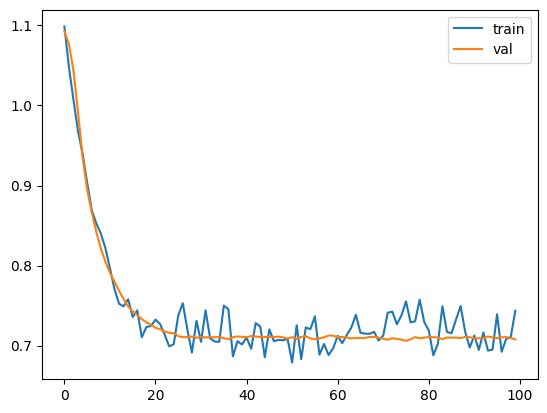

In [747]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train','val'])
plt.show();

### Validation accuracy 

In [748]:
cats

['air', 'vac', 'off']

In [749]:
preds, *rest = classifier(Xval)

In [750]:
preds.argmax(axis=1)

tensor([2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0])

In [751]:
yval.argmax(axis=1)

tensor([2, 1, 1, 2, 1, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0])

In [752]:
(preds.argmax(axis=1) == yval.argmax(axis=1)).float().mean()

tensor(0.9444)

### Train accuracy 

In [753]:
torch.tensor([cats.index(val) for val in ytrain])

tensor([2, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 1, 2,
        1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0,
        1, 2, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1])

In [754]:
train_preds, *rest = classifier(Xtrain)
train_preds.argmax(axis=1)

tensor([2, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 1, 2,
        1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0,
        1, 2, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1])

In [755]:
(torch.tensor([cats.index(val) for val in ytrain]) == train_preds.argmax(axis=1)).float().mean()

tensor(1.)

# Test accuracy

In [756]:
xcvxcvytest

NameError: name 'xcvxcvytest' is not defined

In [ ]:
torch.tensor([cats.index(val) for val in ytest])
test_preds, *rest = classifier(Xtest)
test_preds.argmax(axis=1)
(torch.tensor([cats.index(val) for val in ytest]) == test_preds.argmax(axis=1)).float().mean()

tensor(0.4167)

In [ ]:
# Load new test data
from pathlib import Path
import librosa
import pandas as pd, numpy as np, matplotlib.pyplot as plt

path = Path("/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_test")
files = list(path.rglob("*.wav"))
df_test = pd.DataFrame({"filepath":files})
df_test["label"] = df_test["filepath"].apply(lambda x: Path(x).parent.name)
df_test["duration"] = df_test["filepath"].apply(lambda x: librosa.get_duration(path=x))
df_test["name"] = df_test["filepath"].apply(lambda x: Path(x).name)


In [ ]:
df_test.sample(5)

,filepath,label,duration,name
17,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,4.0,off_3.wav
3,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,4.0,air_3.wav
8,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,4.0,vac_1.wav
9,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,4.0,vac_0.wav
11,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,4.0,vac_3.wav


In [ ]:
df_test = df_test.drop(df_test[(df_test.duration < 3.9)].index)

In [ ]:
df_test = df_test[~df_test.name.str.contains("_0.wav")]

In [ ]:
Xtest = torch.stack([Transform.load_audio(fp) for fp in df_test.filepath])
ytest = list(df_test.label)

In [ ]:
test_ds = ApplianceDS(Xtest, ytest)

In [ ]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [ ]:
torch.tensor([cats.index(val) for val in ytest])

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

In [ ]:
test_preds, *rest = classifier(Xtest)
test_preds.argmax(axis=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1])

In [ ]:
test_ds = ApplianceDS(Xtrain, ytrain)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [ ]:
torch.tensor([cats.index(val) for val in ytest])
test_preds, *rest = classifier(Xtest)
test_preds.argmax(axis=1)
(torch.tensor([cats.index(val) for val in ytest]) == test_preds.argmax(axis=1)).float().mean()

tensor(0.5000)

# Save the model

In [ ]:
path.name
from datetime import datetime

In [757]:
classifier_name = str(path.name)
time = datetime.today().strftime('%Y_%m_%d__%H_%M')
torch.save(classifier, f"{classifier_name}_finetuned_model_{time}.pt")


In [ ]:
cats

['air', 'vac', 'off']